# Project

# Data

The dataset<sup><a name="note-cariboo" href="#cariboo">[7]</a></sup> is composed of 7 different subsets, we will be using 4 of the datasets. Since each feature resides in different sets. 

- `Appearances.csv`
    - Player ID, Game ID, Appearance ID, Competition ID, Player club ID, Assist, Minutes Played, Yellow cards, Red Cards
- `Clubs.csv `
    - Club ID, Name, Pretty_name, Domestic_competition_id, Total_market_value, Squad_size, Average_age, Foreigners_numbers, Foreigners_percentage, National_team_players, Stadium_name, Stadium_seats, Net_transfer_record, Coach_name, URL
- `Competitions.csv`
    - Competition_id, Name, type, country_id, country_name, domestic_league_code, confederation, URL.  
- `Games.csv` 
    - Game_id, Competition_code, Season, Round, Date, Home_club_id, Away_club_id, Home_club_goals, away_club_goals, Home_club_postions, Away_club_postion, Stadium, Attendance, Referee, URL 
- `Leagues.csv` 
    - League_id, name, Confederation
- `Player_valuations.csv` 
    - Player_id, Date, Market_value
- `Players.csv`
    - Player_id, Last_season, Current_club_id, Name, Pretty_name, country_of_birth, Country_of_citizenship, Date_of_birth, Position, Sub_position, Foot, Height_in_cm, Market_value_in_gbp, Highest_market_value_in_gbp, URL

- _What an observation consists of_: We are trying to use the variables we assume to be the most important and independent from each other. We decided on 
    - Club, Nationality, League, Appearances, Minutes, Goals, Assist, Age, Conduct, Media Presence, Years Played, Trophies, Experience, Position, Physicality, Potential. 
- _What some critical variables are, how they are represented_: We want variables which have the highest co-variance with each other. The metric should handle most features as unique features. 
- _Any special handling, transformations, cleaning, etc will be needed_: There will be club names, and probably inferences in our data. Such as Media Presence or Potential, these are metrics which can be objective to the person. How popular is the player that we are analyzing? 

We are still going to be in search of more databases that might have different descriptive data that we might like to see how organizations search for talent. We can use what they might describe as their most sought out characteristics. 

For Simplicity we can also assume that all players have no contracts for their evaluation and are based solely on performance and the other variables mentioned.

In [1]:
!{__import__('sys').executable} -m pip install --quiet pandas

In [2]:
import pandas as pd

data = {
    name: pd.read_csv(
        file, 
        engine = 'c',
        low_memory = True,
        memory_map = False, # set `False` to load into memory
        **kwargs
    ) for name, file, kwargs in [
        ('appearances', 'data/appearances.csv', {}),
        ('clubs', 'data/clubs.csv', {}),
        ('competitions', 'data/competitions.csv', {}),
        ('games', 'data/games.csv', {}),
        ('leagues', 'data/leagues.csv', {}),
        ('players', 'data/players.csv', {
            'parse_dates': ['date_of_birth'],
            'dtype': {
                'last_season': 'category',
                'country_of_birth': 'category',
                'country_of_citizenship': 'category',
                'position': 'category',
                'sub_position': 'category'
            }
        }),
        ('player_valuations', 'data/player_valuations.csv', {})
    ]
}

In [3]:
data['clubs'] = data['clubs'][
    ['club_id', 'name', 'total_market_value']
]
data['clubs'].rename(
    columns = {
        'name': 'club_name',
        'total_market_value': 'club_total_market_value_in_gbp'
    },
    inplace = True
)
data['clubs'].set_index('club_id', inplace = True)

data['clubs']

,club_name,club_total_market_value_in_gbp
club_id,,
1032,fc-reading,33.66
2323,orduspor,NaN
1387,acn-siena-1904,4.32
3592,kryvbas-kryvyi-rig,2.95
1071,wigan-athletic,12.38
...,...,...
1269,pec-zwolle,12.80
200,fc-utrecht,31.55
317,fc-twente-enschede,19.04


In [4]:
data['appearances'] = data['appearances'].loc[
    :, ~data['appearances'].columns.isin([
        'game_id', 
        'appearance_id', 
        'competition_id', 
        'player_club_id'
    ])
]
data['appearances'].set_index('player_id', inplace = True)

data['appearances']

,goals,assists,minutes_played,yellow_cards,red_cards
player_id,,,,,
52453,0,0,90,0,0
67064,0,0,90,0,0
67064,0,0,90,0,0
67064,0,0,55,0,0
67064,0,0,90,0,0
...,...,...,...,...,...
408574,1,0,90,0,0
408574,1,1,90,0,0
408574,0,1,27,0,0


In [5]:
data['player_valuations'].rename(
    columns = {'market_value': 'market_value_in_gbp'},
    inplace = True
)
data['player_valuations'].set_index(['player_id'], inplace = True)

data['player_valuations']

,date,market_value_in_gbp
player_id,,
254016,2013-07-22,90000
254016,2014-01-14,90000
51053,2008-08-25,90000
51053,2011-05-30,90000
51053,2011-08-26,225000
...,...,...
575367,2020-04-08,563000
575367,2020-06-29,675000
575367,2020-12-31,765000


In [6]:
data['players'] = data['players'].loc[
    :, ~data['players'].columns.isin([
        'market_value_in_gbp',
        'url', 
        'foot'
    ])
]
data['players'].rename(
    columns = {'current_club_id': 'club_id'},
    inplace = True
)
data['players'].set_index('player_id', inplace = True)

data['players']

,last_season,club_id,name,pretty_name,country_of_birth,country_of_citizenship,date_of_birth,position,sub_position,height_in_cm,highest_market_value_in_gbp
player_id,,,,,,,,,,,
254016,2013,855,arthur-delalande,Arthur Delalande,France,France,1992-05-18,Midfield,midfield - Central Midfield,186,90000.0
51053,2013,23,daniel-davari,Daniel Davari,Germany,Iran,1988-01-06,Goalkeeper,Goalkeeper,192,1130000.0
31451,2013,23,torsten-oehrl,Torsten Oehrl,Germany,Germany,1986-01-07,Attack,attack - Centre-Forward,192,1130000.0
44622,2013,3691,vladimir-kisenkov,Vladimir Kisenkov,UdSSR,Russia,1981-10-08,Defender,Defender - Right-Back,182,720000.0
30802,2013,3302,oscar-diaz,Oscar Diaz,Spain,Spain,1984-04-24,Attack,attack - Centre-Forward,183,1080000.0
...,...,...,...,...,...,...,...,...,...,...,...
462285,2021,200,fabian-de-keijzer,Fabian De Keijzer,Netherlands,Netherlands,2000-05-10,Goalkeeper,Goalkeeper,193,540000.0
368612,2021,3057,merveille-bokadi,Merveille Bokadi,Zaire,DR Congo,1996-05-21,Defender,Defender - Centre-Back,186,3150000.0
408574,2021,383,joey-veerman,Joey Veerman,Netherlands,Netherlands,1998-11-19,Midfield,midfield - Central Midfield,185,7650000.0


In [7]:
df = data['players'].merge(
    data['player_valuations'], 
    on = 'player_id',
    copy = False
).merge(
    data['appearances'], 
    on = 'player_id',
    copy = False
).merge(
    data['clubs'], 
    on = 'club_id',
    copy = False
).drop(columns = 'club_id')
df.dropna(subset = [
    'market_value_in_gbp', 
    'club_total_market_value_in_gbp'
], inplace = True)

df

,last_season,name,pretty_name,country_of_birth,country_of_citizenship,date_of_birth,position,sub_position,height_in_cm,highest_market_value_in_gbp,date,market_value_in_gbp,goals,assists,minutes_played,yellow_cards,red_cards,club_name,club_total_market_value_in_gbp
17413,2013,gaetano-berardi,Gaetano Berardi,Switzerland,Switzerland,1988-08-21,Defender,Defender - Right-Back,179,1260000.0,2006-08-16,45000,0,0,45,0,0,sampdoria-genua,86.31
17414,2013,gaetano-berardi,Gaetano Berardi,Switzerland,Switzerland,1988-08-21,Defender,Defender - Right-Back,179,1260000.0,2006-08-16,45000,0,0,69,0,0,sampdoria-genua,86.31
17415,2013,gaetano-berardi,Gaetano Berardi,Switzerland,Switzerland,1988-08-21,Defender,Defender - Right-Back,179,1260000.0,2008-08-01,90000,0,0,45,0,0,sampdoria-genua,86.31
17416,2013,gaetano-berardi,Gaetano Berardi,Switzerland,Switzerland,1988-08-21,Defender,Defender - Right-Back,179,1260000.0,2008-08-01,90000,0,0,69,0,0,sampdoria-genua,86.31
17417,2013,gaetano-berardi,Gaetano Berardi,Switzerland,Switzerland,1988-08-21,Defender,Defender - Right-Back,179,1260000.0,2009-06-22,405000,0,0,45,0,0,sampdoria-genua,86.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23386683,2021,cameron-puertas,Cameron Puertas,Switzerland,Spain,1998-08-18,Midfield,midfield - Central Midfield,178,1800000.0,2022-04-12,1530000,0,0,19,0,0,royale-union-saint-gilloise,47.63
23386684,2021,cameron-puertas,Cameron Puertas,Switzerland,Spain,1998-08-18,Midfield,midfield - Central Midfield,178,1800000.0,2022-04-12,1530000,0,0,4,1,0,royale-union-saint-gilloise,47.63
23386685,2021,cameron-puertas,Cameron Puertas,Switzerland,Spain,1998-08-18,Midfield,midfield - Central Midfield,178,1800000.0,2022-04-12,1530000,0,0,3,0,0,royale-union-saint-gilloise,47.63
23386686,2021,cameron-puertas,Cameron Puertas,Switzerland,Spain,1998-08-18,Midfield,midfield - Central Midfield,178,1800000.0,2022-04-12,1530000,0,0,45,0,0,royale-union-saint-gilloise,47.63


In [8]:
df.dtypes

last_season                             category
name                                      object
pretty_name                               object
country_of_birth                        category
country_of_citizenship                  category
date_of_birth                     datetime64[ns]
position                                category
sub_position                            category
height_in_cm                               int64
highest_market_value_in_gbp              float64
date                                      object
market_value_in_gbp                        int64
goals                                      int64
assists                                    int64
minutes_played                             int64
yellow_cards                               int64
red_cards                                  int64
club_name                                 object
club_total_market_value_in_gbp           float64
dtype: object

In [9]:
df.describe()

,height_in_cm,highest_market_value_in_gbp,market_value_in_gbp,goals,assists,minutes_played,yellow_cards,red_cards,club_total_market_value_in_gbp
count,2.298890e+07,2.298890e+07,2.298890e+07,2.298890e+07,2.298890e+07,2.298890e+07,2.298890e+07,2.298890e+07,2.298890e+07
mean,1.815738e+02,1.244445e+07,5.417580e+06,1.043819e-01,7.827848e-02,7.171878e+01,1.509275e-01,3.595648e-03,1.541642e+02
std,1.300925e+01,1.868781e+07,1.088807e+07,3.474421e-01,2.908788e-01,2.866189e+01,3.692615e-01,5.985583e-02,1.982415e+02
min,0.000000e+00,9.000000e+03,9.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+00
25%,1.780000e+02,1.800000e+06,4.500000e+05,0.000000e+00,0.000000e+00,6.100000e+01,0.000000e+00,0.000000e+00,1.960000e+01
50%,1.830000e+02,5.400000e+06,1.440000e+06,0.000000e+00,0.000000e+00,9.000000e+01,0.000000e+00,0.000000e+00,7.414000e+01
75%,1.870000e+02,1.530000e+07,5.400000e+06,0.000000e+00,0.000000e+00,9.000000e+01,0.000000e+00,0.000000e+00,2.187900e+02
max,2.060000e+02,1.800000e+08,1.800000e+08,6.000000e+00,6.000000e+00,1.200000e+02,2.000000e+00,1.000000e+00,8.633700e+02


# Evaluation Metrics

We will be using an OLS regression model and the evaluation techniques we are considering are RMSE and Euclidean distance.
A possible evaluation metric we will use is RMSE or Mean Absolute Value of Errors. It is derived by calculating the difference between the estimated and actual value, square those results, then calculate the mean of those results. The formula for RMSE is 

$$
    \text{RMSE} = \sqrt{\frac{\sum_{i = 1}^{N}\left(\text{Predicted}_{i} - \text{Actual}_{i}\right)^{2}}{N}}
$$

# Preliminary results

In [10]:
!{__import__('sys').executable} -m pip install --quiet statsmodels numpy seaborn

In [11]:
# OLS using statsmodels
import statsmodels.api as sm
import numpy as np

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [12]:
# feature selection
X = df[[
    'goals', 
    'assists', 
    'minutes_played', 
    'yellow_cards', 
    'red_cards', 
    'height_in_cm'
]]
y = df['market_value_in_gbp']

X = sm.add_constant(X)

OLS_model = sm.OLS(y, X).fit()
OLS_model.summary()

# X coeffecients and constant terms for prediction/plot
params = OLS_model.params

print(OLS_model.summary())
print(params)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                             OLS Regression Results                            
Dep. Variable:     market_value_in_gbp   R-squared:                       0.016
Model:                             OLS   Adj. R-squared:                  0.016
Method:                  Least Squares   F-statistic:                 6.186e+04
Date:                 Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                         16:41:15   Log-Likelihood:            -4.0493e+08
No. Observations:             22988899   AIC:                         8.099e+08
Df Residuals:                 22988892   BIC:                         8.099e+08
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.544e+06   3.18e+

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns

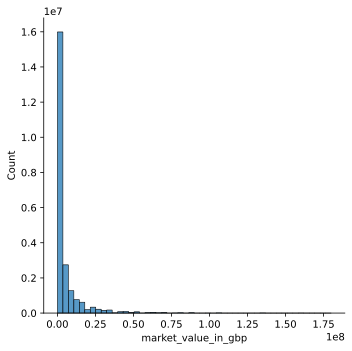

In [14]:
sns.displot(data = df, x = 'market_value_in_gbp', bins = 50)

plt.show()

In [15]:
df_highest_market_value_players = df.nlargest(n = 1, columns = 'market_value_in_gbp')

df_highest_market_value_players

,last_season,name,pretty_name,country_of_birth,country_of_citizenship,date_of_birth,position,sub_position,height_in_cm,highest_market_value_in_gbp,date,market_value_in_gbp,goals,assists,minutes_played,yellow_cards,red_cards,club_name,club_total_market_value_in_gbp
14461191,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2018-12-17,180000000,0,1,34,0,0,fc-paris-saint-germain,813.11


In [16]:
df_highest_market_value = df.loc[df['name'].isin(df_highest_market_value_players['name'])]

df_highest_market_value

,last_season,name,pretty_name,country_of_birth,country_of_citizenship,date_of_birth,position,sub_position,height_in_cm,highest_market_value_in_gbp,date,market_value_in_gbp,goals,assists,minutes_played,yellow_cards,red_cards,club_name,club_total_market_value_in_gbp
14458323,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2015-12-02,45000,0,1,34,0,0,fc-paris-saint-germain,813.11
14458324,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2015-12-02,45000,0,0,2,0,0,fc-paris-saint-germain,813.11
14458325,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2015-12-02,45000,0,0,20,0,0,fc-paris-saint-germain,813.11
14458326,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2015-12-02,45000,0,0,5,0,0,fc-paris-saint-germain,813.11
14458327,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2015-12-02,45000,0,0,12,0,0,fc-paris-saint-germain,813.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14463098,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2021-12-16,144000000,1,0,90,0,0,fc-paris-saint-germain,813.11
14463099,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2021-12-16,144000000,0,0,90,0,0,fc-paris-saint-germain,813.11
14463100,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2021-12-16,144000000,2,1,90,0,0,fc-paris-saint-germain,813.11
14463101,2021,kylian-mbappe,Kylian Mbappe,France,France,1998-12-20,Attack,attack - Centre-Forward,178,180000000.0,2021-12-16,144000000,0,1,90,0,0,fc-paris-saint-germain,813.11


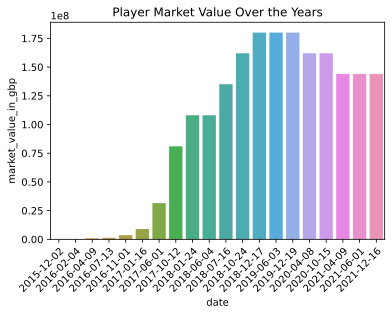

In [17]:
sns.barplot(data = df_highest_market_value, x = 'date', y = 'market_value_in_gbp')
plt.title('Player Market Value Over the Years')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')

plt.show()

# Footnotes

<sup><a name="cariboo" href="#note-cariboo">7</a></sup> *Football Data from Transfermarkt.* (2022, April 22). [Dataset]. https://www.kaggle.com/datasets/davidcariboo/player-scores